This example injects a fixed-frequency tone near the resonator frequency. Then it triggers the resonator in order to move it. The captured data shows the time-domain amplitude variation due to the movement of the resonator frequency.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('soft/')

from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('./qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU208

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [13]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

# Enable resonator.
#simu.enable(499.3)
#simu.enable(503)
#simu.enable(800)
#simu.enable(1105)

#simu.disable(595)
#simu.disable(600)
#simu.disable(605)

In [16]:
cfg = {'sel':'resonator', 'freq':600,'sweep_time':10,'dds_wait':1}
simu.set_resonator(cfg)

In [17]:
class ResonatorJump(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['ro_freq'],
                             sel     = self.cfg['ro_sel'],
                             gen_ch  = self.cfg['gen_ch'])        
        
        self.synci(200)  # give processor some time to configure pulses      
    
    def body(self):
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="oneshot")
        
        # Trigger.
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=0)
        #self.trigger(pins=[12,13,14,15,16,17,18,19],t=self.us2cycles(self.cfg['trigger_off']+self.cfg['jump_off']))

        # Pulse.
        self.pulse(ch = self.cfg['gen_ch'])
        
        # Resonator Jump.
        self.trigger(pins=[12,13,14,15,16,17,18,19],t=self.us2cycles(self.cfg['trigger_off']))
        
config={"gen_ch"      : 4,
        "reps"        : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 599, # [MHz]
        "trigger_off" : 5,
       }

ro_cfg = {
    "ro_ch"     : 4,
    "ro_length" : 30,
    "ro_sel"    : 'product',
    "ro_freq"   : 600,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

prog = ResonatorJump(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

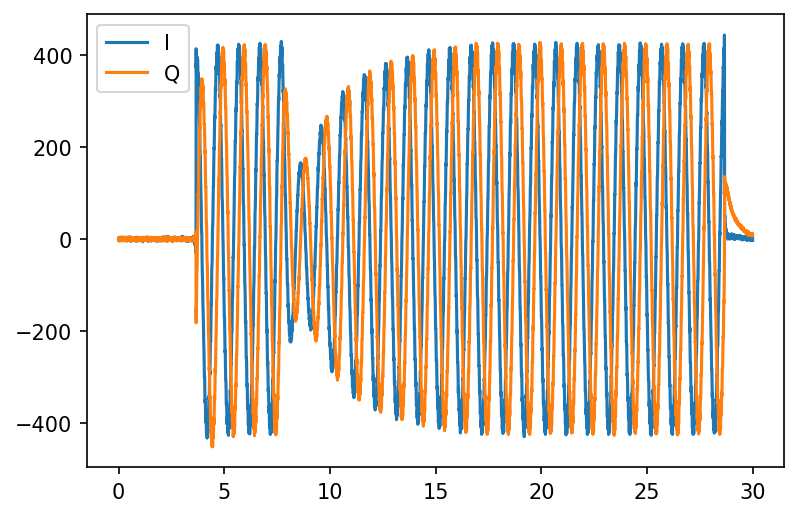

In [18]:
plt.figure(dpi=150)

# Time index.
iq = iq_list[0]
t = soccfg.cycles2us(np.arange(len(iq_list[0])), ro_ch=config['ro_ch'])
n=range(len(iq_list[0]))
plt.plot(t, iq[:,0], label='I')
plt.plot(t, iq[:,1], label='Q')
plt.legend();